# Starting Machine Learning Model

## Importing Libs

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pycaret as pc
from pycaret.regression import setup, compare_models
import numpy as np
import seaborn as sns

## Reading the Data

In [3]:
def resetIndex(data):
    data = data.reset_index()
    return data.head()

In [4]:
FedFundsRate = pd.read_excel('../data/FedFundsRate.xlsx', index_col=0, engine='openpyxl')
resetIndex(FedFundsRate)

,observation_date,FedFundsRate
0,1969-03-01,6.793226
1,1969-04-01,7.414667
2,1969-05-01,8.670323
3,1969-06-01,8.901333
4,1969-07-01,8.613226


In [5]:
M2 = pd.read_excel('../data/M2.xlsx', index_col=0, engine='openpyxl')
resetIndex(M2)

,observation_date,M2
0,1980-11-01,1598.525
1,1980-12-01,1603.140
2,1981-01-01,1612.900
3,1981-02-01,1608.125
4,1981-03-01,1629.400


In [6]:
Median_CPI = pd.read_excel('../data/Median_CPI.xlsx', index_col=0, engine='openpyxl')
resetIndex(Median_CPI)

,observation_date,Median CPI
0,1983-01-01,5.014653
1,1983-02-01,4.952545
2,1983-03-01,3.612261
3,1983-04-01,4.828054
4,1983-05-01,3.767326


In [7]:
Stick_CPI = pd.read_excel('../data/StickyCPI_Less_Food_And_Energy.xlsx', index_col=0, engine='openpyxl')
resetIndex(Stick_CPI)

,observation_date,StickyCPI
0,1968-01-01,3.651861
1,1968-02-01,3.673819
2,1968-03-01,4.142164
3,1968-04-01,4.155828
4,1968-05-01,4.088245


In [8]:
UnemploymentRate_25_34Y = pd.read_excel('../data/UnemploymentRate_25-34Y.xlsx', index_col=0, engine='openpyxl')
resetIndex(UnemploymentRate_25_34Y)

,observation_date,UnemploymentRate_25-34Y
0,1948-01-01,3.0
1,1948-02-01,3.3
2,1948-03-01,2.9
3,1948-04-01,3.4
4,1948-05-01,3.0


In [9]:
UnemploymentRate_45_54Y = pd.read_excel('../data/UnemploymentRate_45-54Y.xlsx', index_col=0, engine='openpyxl')
resetIndex(UnemploymentRate_45_54Y)

,observation_date,UnemploymentRate_45-54Y
0,1948-01-01,2.2
1,1948-02-01,2.8
2,1948-03-01,2.6
3,1948-04-01,2.6
4,1948-05-01,2.4


In [10]:
UnemploymentRate_55_64Y = pd.read_excel('../data/UnemploymentRate_55-64Y.xlsx', index_col=0, engine='openpyxl')
resetIndex(UnemploymentRate_55_64Y)

,observation_date,UnemploymentRate_55-64Y
0,1948-01-01,3.6
1,1948-02-01,4.1
2,1948-03-01,3.3
3,1948-04-01,3.4
4,1948-05-01,2.9


In [11]:
UnemploymentRate_65_OverY = pd.read_excel('../data/UnemploymentRate_65-OverY.xlsx', index_col=0, engine='openpyxl')
resetIndex(UnemploymentRate_65_OverY)

,observation_date,UnemploymentRate_65-OverY
0,1948-01-01,3.7
1,1948-02-01,4.0
2,1948-03-01,4.2
3,1948-04-01,2.8
4,1948-05-01,3.2


In [12]:
ComercialAndIndustrialLoans = pd.read_excel('../data/Commercial and Industrial Loans, All Commercial Banks, Percent Change at Annual Rate.xlsx', index_col=0, engine='openpyxl')
resetIndex(ComercialAndIndustrialLoans)

,observation_date,"Commercial and Industrial Loans, All Commercial Banks, Percent Change at Annual Rate"
0,1947-02-01,18.2
1,1947-03-01,26.9
2,1947-04-01,26.3
3,1947-05-01,25.7
4,1947-06-01,25.2


In [13]:
FederalDebt = pd.read_excel('../data/Federal Debt Total Public Debt as Percent of Gross Domestic Product, Percent of GDP.xlsx', index_col=0, engine='openpyxl')
resetIndex(FederalDebt)

,observation_date,"Federal Debt Total Public Debt as Percent of Gross Domestic Product, Percent of GDP"
0,1966-01-01,40.33999
1,1966-04-01,39.26763
2,1966-07-01,39.62091
3,1966-10-01,39.51977
4,1967-01-01,39.20383


In [14]:
FederalDebt = FederalDebt.resample('D').ffill()

FederalDebt.reset_index(inplace=True)

FederalDebt.head()


,observation_date,"Federal Debt Total Public Debt as Percent of Gross Domestic Product, Percent of GDP"
0,1966-01-01,40.33999
1,1966-01-02,40.33999
2,1966-01-03,40.33999
3,1966-01-04,40.33999
4,1966-01-05,40.33999


## Merge Data

In [15]:
def merge(*dfs):
    if len(dfs) < 2:
        raise ValueError("Insufficient number of DataFrames to merge. Please provide at least 2 DataFrames.")
    
    merged_df = dfs[0]
    
    for df in dfs[1:]:
        merged_df = pd.merge(merged_df, df, on='observation_date', how='inner')
    
    return merged_df

In [16]:
merged_df = merge(FedFundsRate, M2, Median_CPI, Stick_CPI, UnemploymentRate_25_34Y, UnemploymentRate_45_54Y, UnemploymentRate_55_64Y, UnemploymentRate_65_OverY, ComercialAndIndustrialLoans, FederalDebt)
resetIndex(merged_df)

,index,observation_date,FedFundsRate,M2,Median CPI,StickyCPI,UnemploymentRate_25-34Y,UnemploymentRate_45-54Y,UnemploymentRate_55-64Y,UnemploymentRate_65-OverY,"Commercial and Industrial Loans, All Commercial Banks, Percent Change at Annual Rate","Federal Debt Total Public Debt as Percent of Gross Domestic Product, Percent of GDP"
0,0,1983-01-01,8.683226,1960.760,5.014653,4.424607,10.6,6.5,6.6,4.5,3.8,35.82911
1,1,1983-02-01,8.508929,1985.750,4.952545,4.356216,10.6,6.6,6.8,4.3,1.3,35.82911
2,2,1983-03-01,8.766129,2008.650,3.612261,4.586332,10.7,6.5,6.8,3.4,1.1,35.82911
3,3,1983-04-01,8.802000,2033.725,4.828054,4.187719,10.1,6.8,6.5,4.0,-3.5,36.87167
4,4,1983-05-01,8.630000,2030.140,3.767326,3.285271,10.1,6.8,5.5,3.8,-2.7,36.87167


## Testing Models

In [17]:
merged_df.to_excel('../data/merged_df.xlsx')

In [19]:
merged_df = pd.read_excel('../data/merged_df.xlsx', index_col=0, engine='openpyxl')
merged_df = merged_df.reset_index()
merged_df = merged_df.drop(columns=['observation_date', 'index'])
merged_df.head()

,FedFundsRate,M2,Median CPI,StickyCPI,UnemploymentRate_25-34Y,UnemploymentRate_45-54Y,UnemploymentRate_55-64Y,UnemploymentRate_65-OverY,"Commercial and Industrial Loans, All Commercial Banks, Percent Change at Annual Rate","Federal Debt Total Public Debt as Percent of Gross Domestic Product, Percent of GDP"
0,8.683226,1960.760,5.014653,4.424607,10.6,6.5,6.6,4.5,3.8,35.82911
1,8.508929,1985.750,4.952545,4.356216,10.6,6.6,6.8,4.3,1.3,35.82911
2,8.766129,2008.650,3.612261,4.586332,10.7,6.5,6.8,3.4,1.1,35.82911
3,8.802000,2033.725,4.828054,4.187719,10.1,6.8,6.5,4.0,-3.5,36.87167
4,8.630000,2030.140,3.767326,3.285271,10.1,6.8,5.5,3.8,-2.7,36.87167


### Finding the best model

In [20]:
setup(merged_df, target='Median CPI')

best_model = compare_models()

,Description,Value
0,Session id,8914
1,Target,Median CPI
2,Target type,Regression
3,Original data shape,"(487, 10)"
4,Transformed data shape,"(487, 10)"
5,Transformed train set shape,"(340, 10)"
6,Transformed test set shape,"(147, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.5845,0.5374,0.7281,0.6052,0.1985,0.3200,0.0110
ridge,Ridge Regression,0.5848,0.5372,0.7276,0.6049,0.1980,0.3166,0.1750
lr,Linear Regression,0.5850,0.5375,0.7278,0.6046,0.1980,0.3161,1.1450
ada,AdaBoost Regressor,0.5927,0.5643,0.7470,0.5905,0.2044,0.3328,0.0370
knn,K Neighbors Regressor,0.6075,0.5809,0.7588,0.5744,0.2045,0.3090,0.0160
huber,Huber Regressor,0.6141,0.5888,0.7621,0.5650,0.2033,0.3072,0.0210
rf,Random Forest Regressor,0.6094,0.5943,0.7678,0.5593,0.2050,0.3081,0.1170
gbr,Gradient Boosting Regressor,0.6112,0.6129,0.7795,0.5468,0.2069,0.3243,0.0530
et,Extra Trees Regressor,0.6362,0.6422,0.7981,0.5277,0.2127,0.3223,0.0780
lightgbm,Light Gradient Boosting Machine,0.6532,0.6600,0.8096,0.5124,0.2170,0.3228,0.0690


### Importing Libs

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel

### BayesianRidge

In [38]:
imputer = SimpleImputer(strategy='mean')  
num_cols = merged_df.select_dtypes(include=[np.number]).columns
df_imputed = pd.DataFrame(imputer.fit_transform(merged_df[num_cols]), columns=num_cols)

X = df_imputed.drop('Median CPI', axis=1)
y = df_imputed['Median CPI']

param_grid = {
    'alpha_1': [1e-6, 1e-5, 1e-4],
    'alpha_2': [1e-6, 1e-5, 1e-4],
    'lambda_1': [1e-6, 1e-5, 1e-4],
    'lambda_2': [1e-6, 1e-5, 1e-4],
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=42)

bayesian_ridge = BayesianRidge()

grid_search = GridSearchCV(estimator=bayesian_ridge, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print("Best Params: ", best_params)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Params:  {'alpha_1': 1e-06, 'alpha_2': 0.0001, 'lambda_1': 0.0001, 'lambda_2': 1e-06}


In [39]:
imputer = SimpleImputer(strategy='mean')  
num_cols = merged_df.select_dtypes(include=[np.number]).columns
df_imputed = pd.DataFrame(imputer.fit_transform(merged_df[num_cols]), columns=num_cols)

X = df_imputed.drop('Median CPI', axis=1)
y = df_imputed['Median CPI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

bayesian_ridge = BayesianRidge()

bayesian_ridge.fit(X_train, y_train)

scores = cross_val_score(bayesian_ridge, X_train, y_train, cv=5) 
print(f"Cross-validation accuracy: {scores.mean()} (+/- {scores.std() * 2})")

test_score = bayesian_ridge.score(X_test, y_test)
print(f"Test data accuracy: {test_score}")

final_decision = bayesian_ridge.predict(X_test[-1:])
print("Final Decision: ", final_decision)

Cross-validation accuracy: 0.5172543588129758 (+/- 0.3154780151377407)
Test data accuracy: 0.7179360711003762
Final Decision:  [1.92704088]


### Ridge

In [41]:
imputer = SimpleImputer(strategy='mean')  
num_cols = merged_df.select_dtypes(include=[np.number]).columns
df_imputed = pd.DataFrame(imputer.fit_transform(merged_df[num_cols]), columns=num_cols)

X = df_imputed.drop('Median CPI', axis=1)
y = df_imputed['Median CPI']

param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

ridge = Ridge()

grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print("Best Params: ", best_params)

Fitting 3 folds for each of 21 candidates, totalling 63 fits
Best Params:  {'alpha': 10.0, 'solver': 'svd'}


In [43]:
ridge = Ridge(**best_params, random_state=42)

selector = SelectFromModel(estimator=ridge).fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

ridge.fit(X_train_selected, y_train)

scores = cross_val_score(ridge, X_train_selected, y_train, cv=5) 
print(f"Cross-validation accuracy: {scores.mean()} (+/- {scores.std() * 2})")

y_pred = ridge.predict(X_test_selected)

test_score = ridge.score(X_test_selected, y_test)
print(f"Test data accuracy: {test_score}")

final_decision = ridge.predict(X_test_selected[-1:])
print("Final Decision: ", final_decision)

Cross-validation accuracy: 0.48949090526072264 (+/- 0.11738401975730611)
Test data accuracy: 0.6224026599194525
Final Decision:  [2.07642263]


### Linear Regression

In [47]:
imputer = SimpleImputer(strategy='mean')  
num_cols = merged_df.select_dtypes(include=[np.number]).columns
df_imputed = pd.DataFrame(imputer.fit_transform(merged_df[num_cols]), columns=num_cols)

X = df_imputed.drop('Median CPI', axis=1)
y = df_imputed['Median CPI']

param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False],
    'copy_X': [True, False]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

linear_reg = LinearRegression()

grid_search = GridSearchCV(estimator=linear_reg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print("Best Params: ", best_params)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Params:  {'copy_X': True, 'fit_intercept': True, 'positive': False}


In [52]:
imputer = SimpleImputer(strategy='mean')  
num_cols = merged_df.select_dtypes(include=[np.number]).columns
df_imputed = pd.DataFrame(imputer.fit_transform(merged_df[num_cols]), columns=num_cols)

X = df_imputed.drop('Median CPI', axis=1)
y = df_imputed['Median CPI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

linear_reg = LinearRegression()

linear_reg.fit(X_train, y_train)

scores = cross_val_score(linear_reg, X_train, y_train, cv=5) 
print(f"Cross-validation accuracy: {scores.mean()} (+/- {scores.std() * 2})")

test_score = linear_reg.score(X_test, y_test)
print(f"Test data accuracy: {test_score}")

final_decision = linear_reg.predict(X_test[-1:])
print("Final Decision: ", final_decision)

Cross-validation accuracy: 0.5307244427785405 (+/- 0.20339472043859536)
Test data accuracy: 0.7020547246453828
Final Decision:  [2.1047078]


### K Neighbors Regressor

In [22]:
imputer = SimpleImputer(strategy='mean')  

num_cols = merged_df.select_dtypes(include=[np.number]).columns

df_imputed = pd.DataFrame(imputer.fit_transform(merged_df[num_cols]), columns=num_cols)

X = df_imputed.drop('Median CPI', axis=1)
y = df_imputed['Median CPI']

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

knn = KNeighborsRegressor()

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print("Best Params: ", best_params)

Fitting 3 folds for each of 320 candidates, totalling 960 fits
Best Params:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


In [23]:
imputer = SimpleImputer(strategy='mean')  
num_cols = merged_df.select_dtypes(include=[np.number]).columns
df_imputed = pd.DataFrame(imputer.fit_transform(merged_df[num_cols]), columns=num_cols)

X = df_imputed.drop('Median CPI', axis=1)
y = df_imputed['Median CPI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knn = KNeighborsRegressor(**best_params)

knn.fit(X_train, y_train)

scores = cross_val_score(knn, X_train, y_train, cv=5) 
print(f"Cross-validation accuracy: {scores.mean()} (+/- {scores.std() * 2})")

test_score = knn.score(X_test, y_test)
print(f"Test data accuracy: {test_score}")

final_decision = knn.predict(X_test[-1:])
print("Final Decision: ", final_decision)

Cross-validation accuracy: 0.6434997185826006 (+/- 0.09912897669157653)
Test data accuracy: 0.7073106430349447
Final Decision:  [2.69512459]


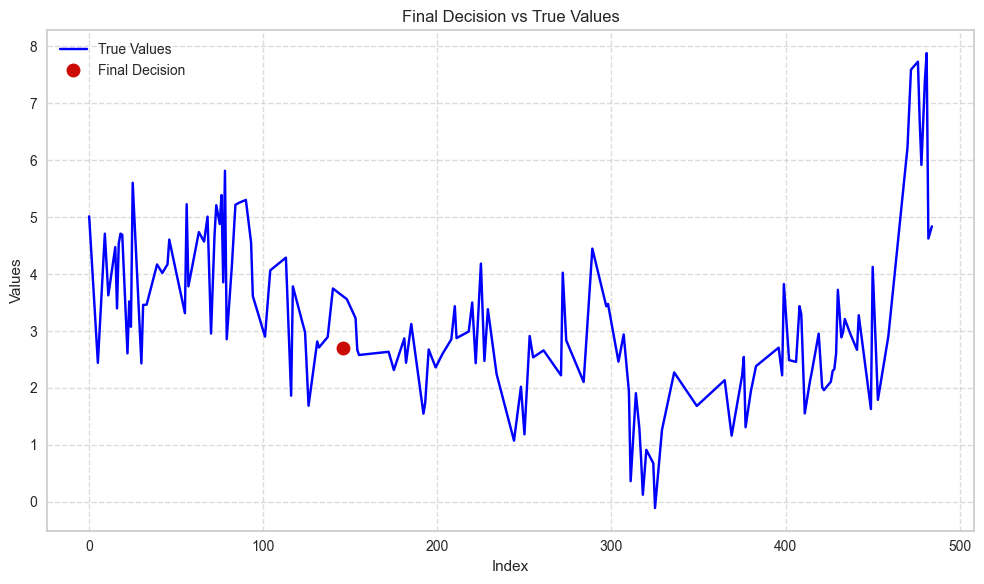

In [24]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=y_test, label='True Values', color='blue')
plt.plot(len(y_test) - 1, final_decision, 'ro', markersize=10, label='Final Decision')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Final Decision vs True Values')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

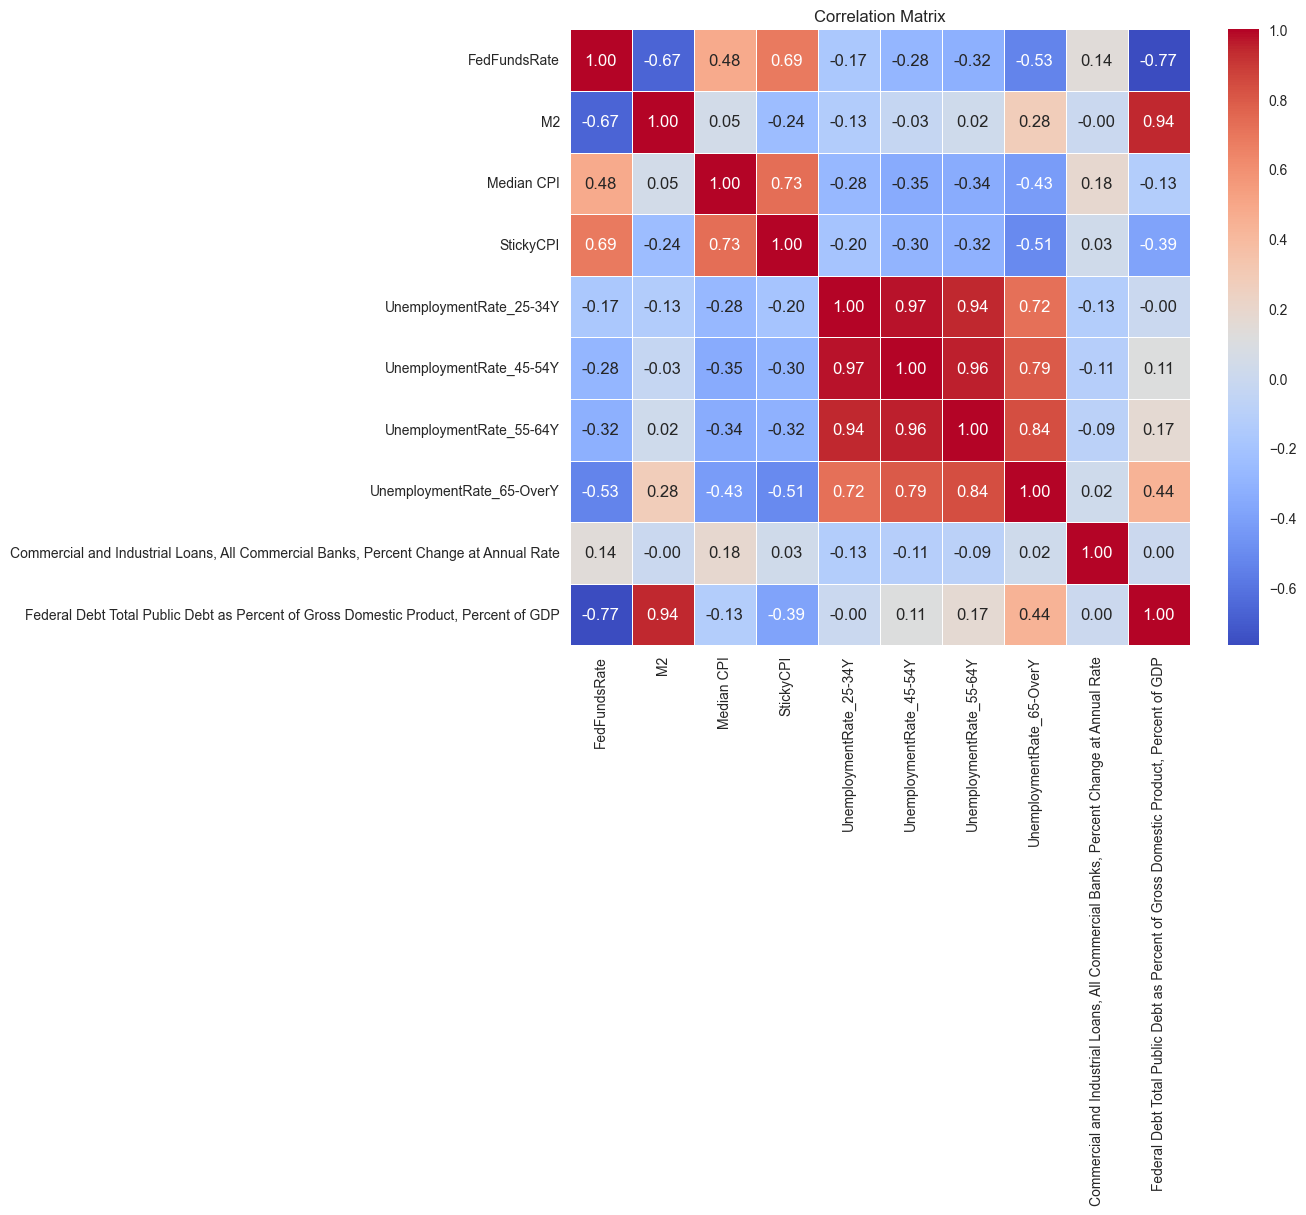

In [25]:
correlation_matrix = merged_df.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Matrix')

plt.show()

### Extra Trees Regressor

In [26]:
imputer = SimpleImputer(strategy='mean')  

num_cols = merged_df.select_dtypes(include=[np.number]).columns

df_imputed = pd.DataFrame(imputer.fit_transform(merged_df[num_cols]), columns=num_cols)

X = df_imputed.drop('Median CPI', axis=1)
y = df_imputed['Median CPI']

param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

et = ExtraTreesRegressor(random_state=42)

grid_search = GridSearchCV(estimator=et, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print("Best Params: ", best_params)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best Params:  {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [27]:
etr = ExtraTreesRegressor(**best_params, random_state=42)

selector = SelectFromModel(estimator=etr).fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

etr.fit(X_train_selected, y_train)

scores = cross_val_score(etr, X_train_selected, y_train, cv=5) 
print(f"Cross-validation accuracy: {scores.mean()} (+/- {scores.std() * 2})")

y_pred = etr.predict(X_test_selected)

test_score = etr.score(X_test_selected, y_test)
print(f"Test data accuracy: {test_score}")

final_decision = etr.predict(X_test_selected[-1:])
print("Final Decision: ", final_decision)

Cross-validation accuracy: 0.6460550758245909 (+/- 0.07710397326416969)
Test data accuracy: 0.7000583654642618
Final Decision:  [2.29253293]


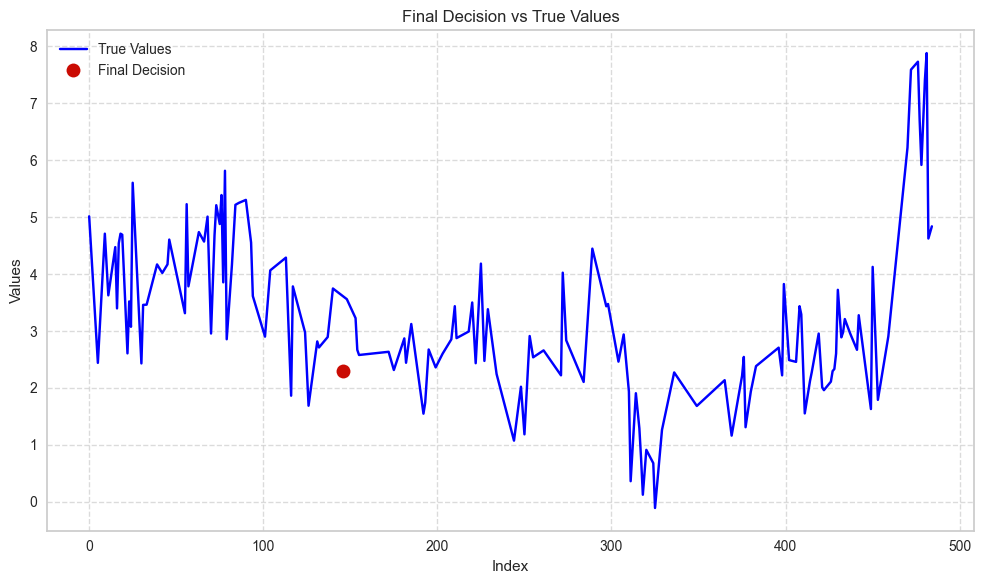

In [28]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=y_test, label='True Values', color='blue')
plt.plot(len(y_test) - 1, final_decision, 'ro', markersize=10, label='Final Decision')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Final Decision vs True Values')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

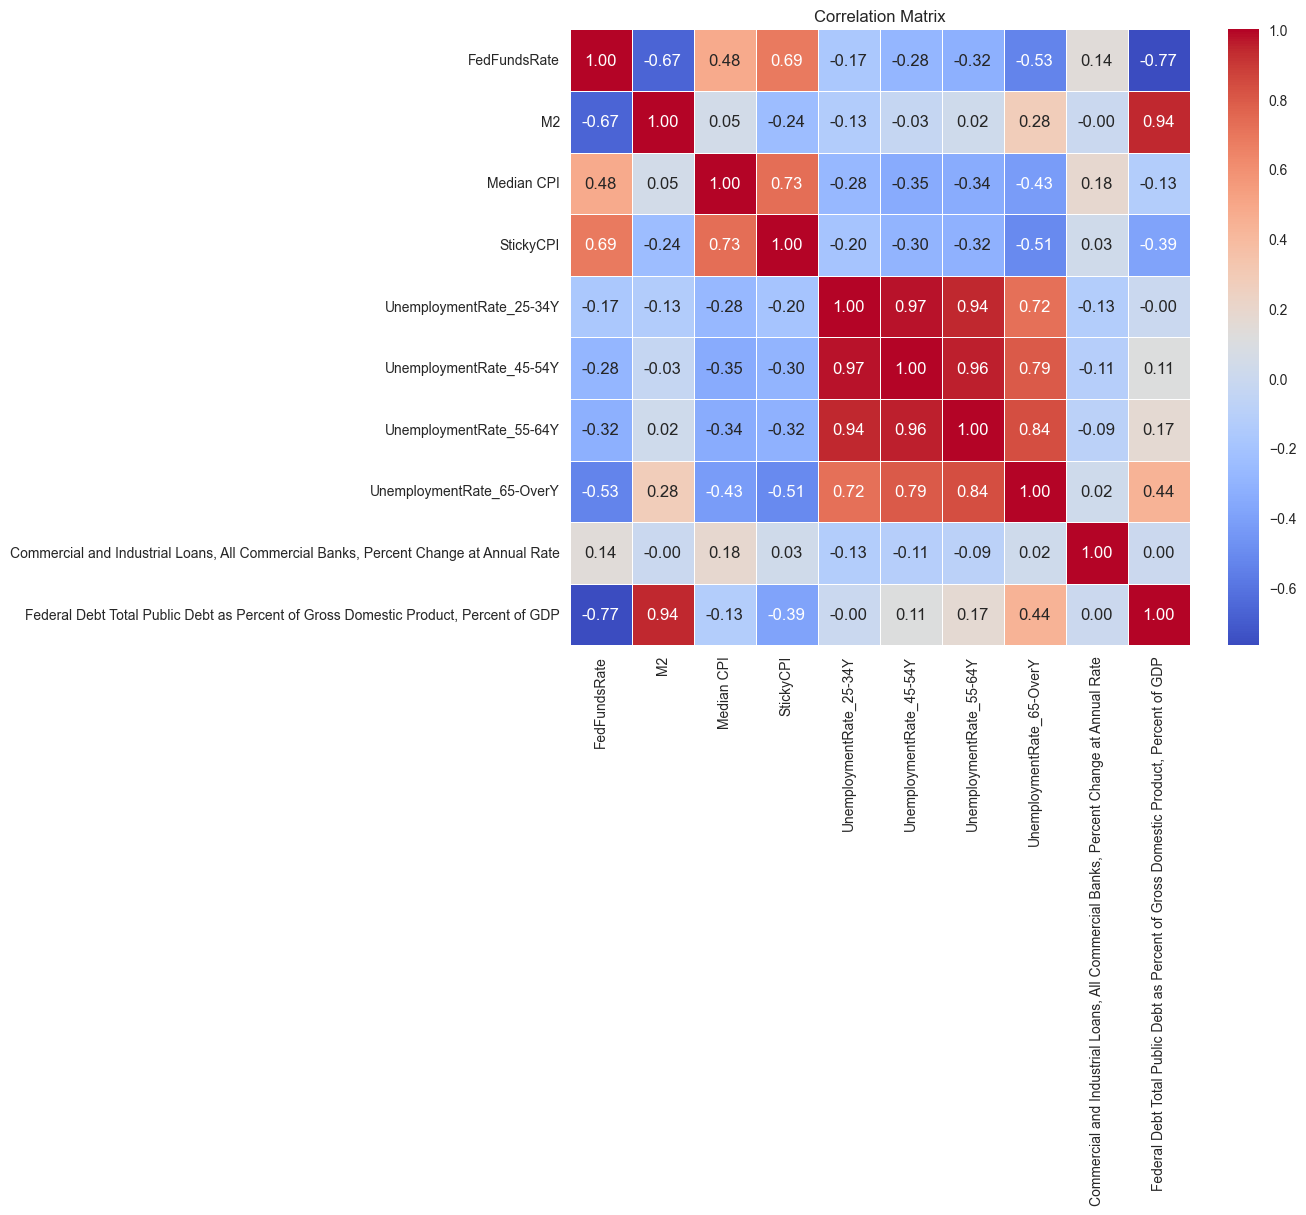

In [29]:
correlation_matrix = merged_df.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Matrix')

plt.show()